# ENHANCE! 

## Super Resolution with OpenVINO

WORK IN PROGRESS NOTEBOOK NOT READY AND FOR PUBLIC RELEASE

[Super Resolution Model description](https://github.com/openvinotoolkit/open_model_zoo/blob/develop/models/intel/single-image-super-resolution-1032/description/single-image-super-resolution-1032.md)

## Install requirements

This may take some time

In [1]:
! pip install --quiet --index-url https://test.pypi.org/simple --extra-index-url https://pypi.org/simple openvino-dev
! pip install matplotlib youtube_dl Pillow

Defaulting to user installation because normal site-packages is not writeable
  Using cached youtube_dl-2021.3.14-py2.py3-none-any.whl (1.9 MB)


## Imports

In [38]:
from base64 import b64encode
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import youtube_dl
from IPython.display import Image as DisplayImage
from IPython.display import HTML
from openvino.inference_engine import IECore
from PIL import Image


## Settings

In [4]:
precision = "FP16"
device = "CPU"
model_name = "single-image-super-resolution-1032"

model_xml = f"intel/{model_name}/{precision}/{model_name}.xml"
if "1032" in model_name:
    SCALE_FACTOR = 4
elif "1033" in model_name:
    SCALE_FACTORCTOR = 3
else:
    print("Unsupported model, please use single-image-super-resolution-1032 or single-image-super-resolution-1033")

C:\Users\havanden\openvino_env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load model and get model information

Load the model in Inference Engine with `ie.read_network` and load it to the specified device with `ie.load_network`

The Super Resolution model expects two inputs: 1) the input image, 2) a bicubic interpolation of the input image to a size of 1920x1080. It returns the super resolution version of the image in 1920x180.

In [5]:
ie = IECore()
net = ie.read_network(model=model_xml, weights=model_xml.replace("xml", "bin"))
exec_net = ie.load_network(network=net, device_name=device)

In [6]:
# Network inputs and outputs are dictionaries. Get the keys for the dictionaries.
original_image_key = list(exec_net.input_info)[0]
bicubic_image_key = list(exec_net.input_info)[1]
output_key = list(exec_net.outputs.keys())[0]

# Get the expected input and target shape. `.dims[2:]` returns the height and width. OpenCV's resize function
# expects the shape as (width, height), so we reverse the shape with `[::-1]` and convert it to a tuple
input_shape = tuple(exec_net.input_info["0"].tensor_desc.dims[2:][::-1])
target_shape = tuple(exec_net.input_info["1"].tensor_desc.dims[2:][::-1])

## Single Image Super Resolution

### Load, resize and reshape input image

The input image is read with OpenCV, resized to network input size, and reshaped to (N,C,H,W) (H=height, W=width, C=number of channels, N=number of images). The image is also resized to network output size, with bicubic interpolation. This bicubic image is the second input to the network.

In [7]:
# Read the image.
image_filename = "images/pat_360.jpg"

image = cv2.imread(image_filename)

# reshape the network
inp_h, inp_w = image.shape[0], image.shape[1]
out_h, out_w = inp_h * SCALE_FACTOR, inp_w * SCALE_FACTOR  # Do not change! This is how model works

# Reshape network to specific size
net.reshape({"0": [1, 3, inp_h, inp_w], "1": [1, 3, out_h, out_w]})
exec_net = ie.load_network(network=net, device_name=device)


portrait = False
if image.shape[0] > image.shape[1]:
    portrait = True
    image = cv2.rotate(image, 2)

# Resize the image to network input shape
# resized_image = cv2.resize(image, input_shape)
# Reshape the image from (H,W,C) to (N,C,H,W)
input_image_original = np.expand_dims(image.transpose(2, 0, 1), axis=0)

# Resize the image to the target shape with bicubic interpolation
bicubic_image = cv2.resize(image, (out_w, out_h), interpolation=cv2.INTER_CUBIC)
input_image_bicubic = np.expand_dims(bicubic_image.transpose(2, 0, 1), axis=0)

### Do inference

In [8]:
result = (
    exec_net.infer(inputs={original_image_key: input_image_original, bicubic_image_key: input_image_bicubic})[
        output_key
    ]
    .squeeze(0)
    .transpose(1, 2, 0)
    * 255
)
result[result < 0] = 0
result[result > 255] = 255
result = result.astype(np.uint8)

In [9]:
if portrait:
    result = cv2.rotate(result, 0)
    bicubic_image = cv2.rotate(bicubic_image, 0)

### Show and save image

DEBUG: Showing subtraction of bicubic and super resolution version for testing purposes

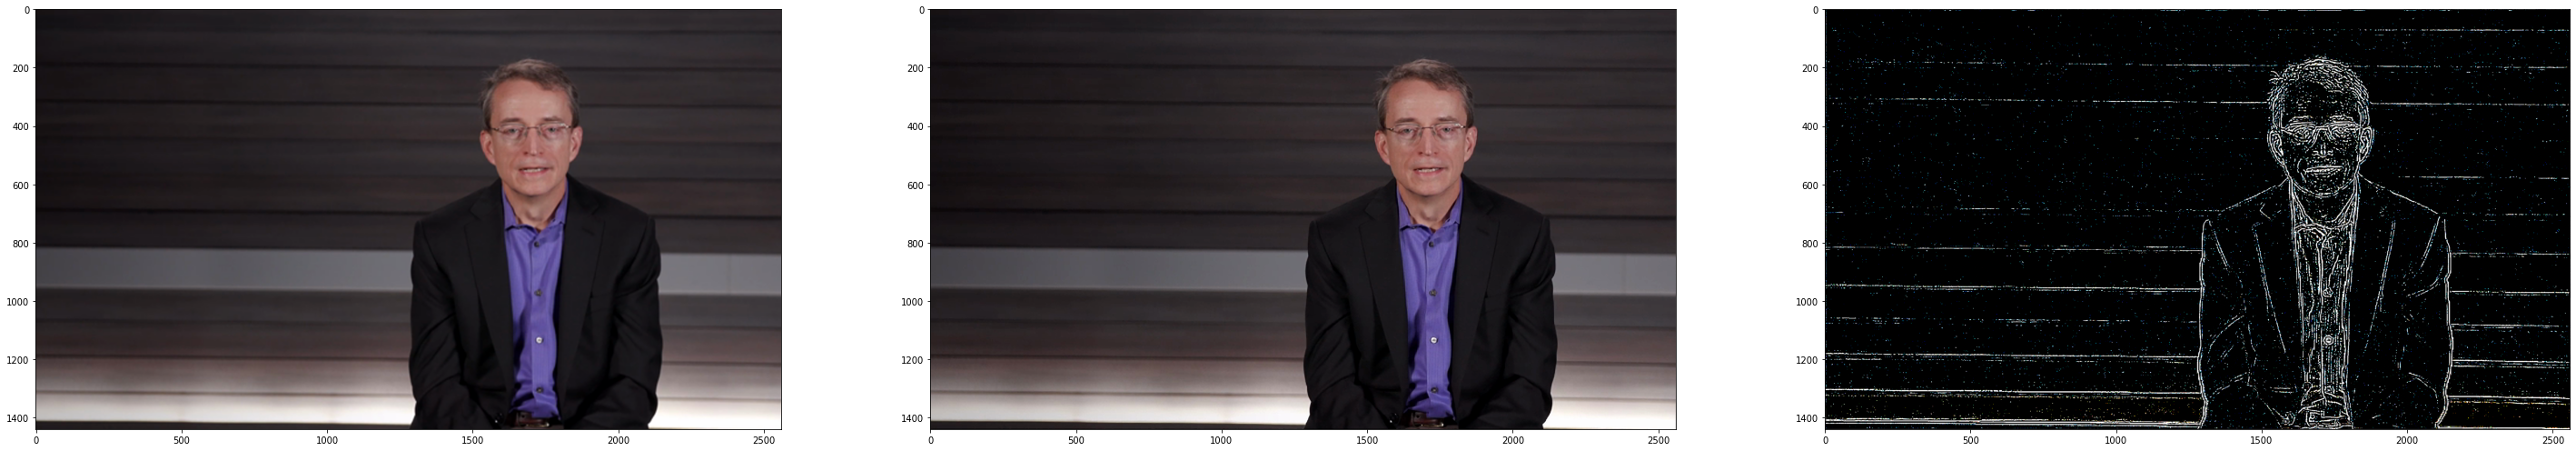

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(50, 15))
ax[0].imshow(bicubic_image[:, :, (2, 1, 0)])
ax[1].imshow(result[:, :, (2, 1, 0)])
ax[2].imshow(bicubic_image - result)

cv2.imwrite(f"{image_filename[:-4]}_bicubic.jpg", bicubic_image)
cv2.imwrite(f"{image_filename[:-4]}_superres.jpg", result);

### Write animated gif with bicubic/superresolution comparison

In [11]:
def write_type(image, image_type):
    font = cv2.FONT_HERSHEY_PLAIN
    org = (20, 20)
    font_scale = 4
    font_color = (255, 255, 255)
    line_type = 1
    font_thickness = 2
    text_color_bg = (0, 0, 0)
    x, y = org

    (text_w, text_h), _ = cv2.getTextSize(image_type, font, font_scale, font_thickness)
    result_im = cv2.rectangle(image, org, (x + text_w, y + text_h), text_color_bg, -1)

    textim = cv2.putText(
        image, image_type, (x, y + text_h + font_scale - 1), font, font_scale, font_color, font_thickness, line_type
    )
    return textim

In [12]:
image_super = write_type(cv2.UMat(result), "SUPER")
image_bicubic = write_type(bicubic_image, "BICUBIC")
cv2.imwrite(f"{image_filename[:-4]}_enhanced.jpg", image_super)
cv2.imwrite(f"{image_filename[:-4]}_bicubic.jpg", image_bicubic);

In [13]:
result_pil = Image.fromarray(image_super.get()[:, :, (2, 1, 0)])
bicubic_pil = Image.fromarray(image_bicubic[:, :, (2, 1, 0)])

In [43]:
gif_filename = f"{image_filename[:-4]}_comparison.gif"
result_pil.save(
    fp=gif_filename,
    format="GIF",
    append_images=[
        bicubic_pil,
    ],
    save_all=True,
    duration=1000,
    loop=0,
)

In [ ]:
DisplayImage(gif_filename)

## Superresolution on Video

DEBUG: Uses Youtube_DL for quickly downloading a video from Youtube. NOT CLEARED WITH LEGAL YET!

Reads first 1200 frames from video. Change NUM_FRAMES below to modify this.

In [40]:
NUM_FRAMES = 1200

# Use youtube_dl to download a video. It downloads to the videos subdirectory. You can also place a local video there and comment out the last three lines
video_dir = "videos"
video_name = "pat.mp4"
video_path = os.path.join(video_dir, video_name)

# Comment this out if the video in video_path already exists
video_url = "https://www.youtube.com/watch?v=V8yS3WIkOrA"
with youtube_dl.YoutubeDL({"outtmpl": video_path}) as ydl:
    ydl.download([video_url])

[youtube] V8yS3WIkOrA: Downloading webpage
[download] Destination: videos\pat.f137.mp4
[download] 100% of 6.65MiB in 00:00                          
[download] Destination: videos\pat.mp4.f140
[download] 100% of 649.94KiB in 00:00                  
[ffmpeg] Merging formats into "videos\pat.mp4"
Deleting original file videos\pat.f137.mp4 (pass -k to keep)
Deleting original file videos\pat.mp4.f140 (pass -k to keep)


In [16]:
portrait = False
resultlist = []
bicubiclist = []
i = 0

# Open the video and read the first frame to get width and height
cap = cv2.VideoCapture(video_path)
ret, image = cap.read()
cap.release()

inp_h, inp_w = image.shape[0], image.shape[1]
out_h, out_w = inp_h * SCALE_FACTOR, inp_w * SCALE_FACTOR  # Do not change! This is how model works

if inp_h > inp_w:
    portrait = True

# Reshape network to video width and height
net.reshape({"0": [1, 3, inp_h, inp_w], "1": [1, 3, out_h, out_w]})
exec_net = ie.load_network(network=net, device_name=device)


# Read all video frames and ENHANCE them. Save the bicubic upsampled and superresolution frames to resultlist and bicubiclist
cap = cv2.VideoCapture(video_path)
while cap.isOpened():
    ret, image = cap.read()
    i = i + 1
    if not ret:
        cap.release()
        break
    if i == NUM_FRAMES:
        break
    if portrait:
        image = cv2.rotate(image, 2)

    # Resize the image to network inputput shape
    # resized_image = cv2.resize(image, input_shape)
    # Reshape the image from (H,W,C) to (N,C,H,W) (H=height, W=width, C=number of channels, N=number of images)
    input_image_original = np.expand_dims(image.transpose(2, 0, 1), axis=0)

    # Resize the image to the target shape with bicubic interpolation
    bicubic_image = cv2.resize(image, (int(out_w), int(out_h)), interpolation=cv2.INTER_CUBIC)
    input_image_bicubic = np.expand_dims(bicubic_image.transpose(2, 0, 1), axis=0)
    result = exec_net.infer(inputs={original_image_key: input_image_original, bicubic_image_key: input_image_bicubic})[
        output_key
    ].squeeze(0)
    result = result.transpose(1, 2, 0) * 255
    result[result > 255] = 255
    result[result < 0] = 0
    result = result.astype(np.uint8)

    resultlist.append(result)
    bicubiclist.append(bicubic_image)

### Write superresolution and bicubic videos to file

In [32]:
cap = cv2.VideoCapture(video_path)

outs = cv2.VideoWriter(
    f"{video_path[:-4]}_superres.avi", cv2.VideoWriter_fourcc("M", "J", "P", "G"), cap.get(cv2.CAP_PROP_FPS), (out_w, out_h)
)
outc = cv2.VideoWriter(
    f"{video_path[:-4]}_bicubic.avi", cv2.VideoWriter_fourcc("M", "J", "P", "G"), cap.get(cv2.CAP_PROP_FPS), (out_w, out_h)
)
out_stacked =  cv2.VideoWriter(
    f"{video_path[:-4]}_stacked.avi", cv2.VideoWriter_fourcc("M", "J", "P", "G"), cap.get(cv2.CAP_PROP_FPS), (out_w * 2, out_h)
)

cap.release()
# resultlist and bicubiclist contain superresolution/bicubic upsampled frames
for resultframe, bicubicframe in zip(resultlist, bicubiclist):
    outs.write(resultframe)
    outc.write(bicubicframe)
    stacked_frame = np.hstack((bicubicframe, resultframe))
    out_stacked.write(stacked_frame)

outs.release()
outc.release()
out_stacked.release()
cap.release()

In [33]:
stacked_video_path = f"{video_path[:-4]}_stacked.avi"

compressed_video_path = stacked_video_path + "_compressed.mp4"
! ffmpeg -i $stacked_video_path -vcodec libx264 $compressed_video_path -hide_banner -loglevel error -y

In [ ]:
mp4 = open(compressed_video_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(
    """
<video width=1200 controls>
      <source src="%s" type="video/mp4">
</video>
"""
    % data_url
)